In [5]:
"""
This notebook demonstrates how to detect brain tumors using a pre-trained MobileNetV2 model with transfer learning.
The dataset consists of 150 "YES" (tumor) and 73 "NO" (no tumor) images. 
Data augmentation is applied to handle class imbalance.

"""

'\nThis notebook demonstrates how to detect brain tumors using a pre-trained MobileNetV2 model with transfer learning.\nThe dataset consists of 150 "YES" (tumor) and 73 "NO" (no tumor) images. \nData augmentation is applied to handle class imbalance.\n\n'

In [7]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import shutil

In [8]:
# Create directories for train, test, and validation sets
os.makedirs("TRAIN/YES", exist_ok=True)
os.makedirs("TRAIN/NO", exist_ok=True)
os.makedirs("TEST/YES", exist_ok=True)
os.makedirs("TEST/NO", exist_ok=True)
os.makedirs("VAL/YES", exist_ok=True)
os.makedirs("VAL/NO", exist_ok=True)

# Verify directory structure
for root, dirs, files in os.walk("."):
    print(root)
    for dir_name in dirs:
        print(os.path.join(root, dir_name))

.
.\.ipynb_checkpoints
.\brain_tumor_dataset
.\TEST
.\TRAIN
.\VAL
.\.ipynb_checkpoints
.\brain_tumor_dataset
.\brain_tumor_dataset\.ipynb_checkpoints
.\brain_tumor_dataset\no
.\brain_tumor_dataset\yes
.\brain_tumor_dataset\.ipynb_checkpoints
.\brain_tumor_dataset\no
.\brain_tumor_dataset\yes
.\TEST
.\TEST\NO
.\TEST\YES
.\TEST\NO
.\TEST\YES
.\TRAIN
.\TRAIN\NO
.\TRAIN\YES
.\TRAIN\NO
.\TRAIN\YES
.\VAL
.\VAL\NO
.\VAL\YES
.\VAL\NO
.\VAL\YES


In [9]:
# Define paths
IMG_PATH = "brain_tumor_dataset" 

# Split the data into train, test, and validation sets
for CLASS in os.listdir(IMG_PATH):
    # Only process yes and no subdirectories. 
    if CLASS in ["yes", "no"]:
        CLASS_DIR = os.path.join(IMG_PATH, CLASS)
        IMG_NUM = len(os.listdir(CLASS_DIR))
        #Iterate Through all the images in the class directory
        for (n, FILE_NAME) in enumerate(os.listdir(CLASS_DIR)):
            img = os.path.join(CLASS_DIR, FILE_NAME)

            # Split based on the ratios (70%, 15%, 15%)
            # Split the data into train, test, and validation sets (70-15-15 split)
            # 70% training: Large portion ensures model learns patterns effectively
            # 15% validation: Enough data to tune hyperparameters and prevent overfitting
            # 15% testing: Sufficient size to evaluate model performance reliably
            if n < 0.7 * IMG_NUM:  # 70% for training
                shutil.copy(img, f'TRAIN/{CLASS.upper()}/{FILE_NAME}')
            elif n < 0.85 * IMG_NUM:  # 15% for validation
                shutil.copy(img, f'VAL/{CLASS.upper()}/{FILE_NAME}')
            else:  # 15% for testing
                shutil.copy(img, f'TEST/{CLASS.upper()}/{FILE_NAME}')

In [10]:
'''
Set up data augmentation for image processing using Keras ImageDataGenerator.
'''
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
'''
Create three data generators for training-validation and testing
'''

# Load data
train_generator = train_datagen.flow_from_directory(
    'TRAIN',
    target_size=(224, 224),
    batch_size=32,  # Increased batch size for stability
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    'VAL',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'TEST',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 157 images belonging to 2 classes.
Found 34 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [12]:
'''
This section sets up the MobileNetV2 model as the base for transfer learning:
- Input shape is set to 224x224x3 (RGB images)
- include_top=False removes the classification layers
- weights='imagenet' loads pre-trained weights
'''
# Load MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  

In [13]:
# Add custom layers with Batch Normalization
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.5),  # Add dropout to reduce overfitting
    Dense(1, activation='sigmoid')
])

In [14]:
'''
Define how the model will learn from data
'''
# Compile the model with gradient clipping
# Gradient clipping at value 1.0 to prevent exploding gradients
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)  # Gradient clipping
model.compile(
    optimizer=optimizer,
    loss=BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)


In [15]:
# Add class weights to address imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [16]:
'''
Prevent the model from getting stuck in local minima by reducing the learning rate.
'''
# Callbacks (only learning rate scheduler)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

In [13]:
'''
Train deep learning model using Keras
'''
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    callbacks=[lr_scheduler],  # Only learning rate scheduler
    class_weight=class_weights
)

C:\Users\ZEYNEP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 846ms/step - accuracy: 0.6300 - auc: 0.6521 - loss: 0.8614 - val_accuracy: 0.7188 - val_auc: 0.8545 - val_loss: 0.9202 - learning_rate: 1.0000e-04
Epoch 2/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6562 - auc: 0.7771 - loss: 0.6125

C:\Users\ZEYNEP\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6562 - auc: 0.7771 - loss: 0.6125 - val_accuracy: 0.7500 - val_auc: 0.8333 - val_loss: 0.7959 - learning_rate: 1.0000e-04
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.7554 - auc: 0.8650 - loss: 0.5088 - val_accuracy: 0.7500 - val_auc: 0.8705 - val_loss: 0.4614 - learning_rate: 1.0000e-04
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5938 - auc: 0.8205 - loss: 0.7940 - val_accuracy: 0.6875 - val_auc: 0.8355 - val_loss: 0.5113 - learning_rate: 1.0000e-04
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.7832 - auc: 0.9345 - loss: 0.4076 - val_accuracy: 0.7500 - val_auc: 0.8312 - val_loss: 0.4436 - learning_rate: 1.0000e-04
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.7812 - auc: 0.9567 - loss: 0.4532 - val_accuracy: 0.7500 - val_auc: 0.8723 - val_loss: 0.4118 - learning_rate: 1.0000e-04
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 565ms/step - accuracy: 0.8147 - auc: 0.9168

In [14]:
# Fine-tune the model by unfreezing some layers
base_model.trainable = True  # Unfreeze the base model
for layer in base_model.layers[:100]:  # Unfreeze the first 100 layers
    layer.trainable = False


In [15]:
# Recompile pre-existing neural network with updated training parameters (lower learning rate)
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss=BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

In [16]:
# Continue training with fine-tuning
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,  # Train for a few more epochs
    callbacks=[lr_scheduler],  # Continue using learning rate scheduler
    class_weight=class_weights
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6433 - auc_1: 0.7102 - loss: 0.8991 - val_accuracy: 0.9062 - val_auc_1: 0.9773 - val_loss: 0.1873 - learning_rate: 1.0000e-05
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.6562 - auc_1: 0.7633 - loss: 0.5055 - val_accuracy: 0.9062 - val_auc_1: 0.9818 - val_loss: 0.1876 - learning_rate: 1.0000e-05
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 698ms/step - accuracy: 0.6451 - auc_1: 0.7586 - loss: 0.7080 - val_accuracy: 0.9375 - val_auc_1: 0.9870 - val_loss: 0.1955 - learning_rate: 1.0000e-05
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7812 - auc_1: 0.8745 - loss: 0.5029 - val_accuracy: 0.9375 - val_auc_1: 0.9864 - val_loss: 0.1848 - learning_rate: 1.0000e-05
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step - accuracy: 0.7245 - auc_1: 0.8464 - loss: 0.5533 - val_accuracy: 0.9062 - val_auc_1: 1.0000 - val_loss: 0.1956 - learning_rate: 1.0000e-05
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - 

In [17]:
'''
Asses how welll the model performs on unseen data.
'''
# Evaluate the model on the test set
results = model.evaluate(test_generator)
test_loss, test_acc, test_auc = results[0], results[1], results[2]
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9062 - auc_1: 0.9909 - loss: 0.2775
Test Loss: 0.2775
Test Accuracy: 0.9062
Test AUC: 0.9909


In [18]:
# Generate predictions
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)

# Get the true labels
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred, target_names=['NO', 'YES']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
              precision    recall  f1-score   support

          NO       0.77      1.00      0.87        10
         YES       1.00      0.86      0.93        22

    accuracy                           0.91        32
   macro avg       0.88      0.93      0.90        32
weighted avg       0.93      0.91      0.91        32



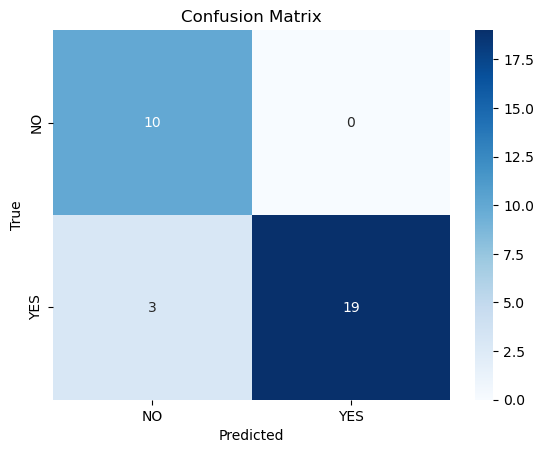

In [19]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Plot training history
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

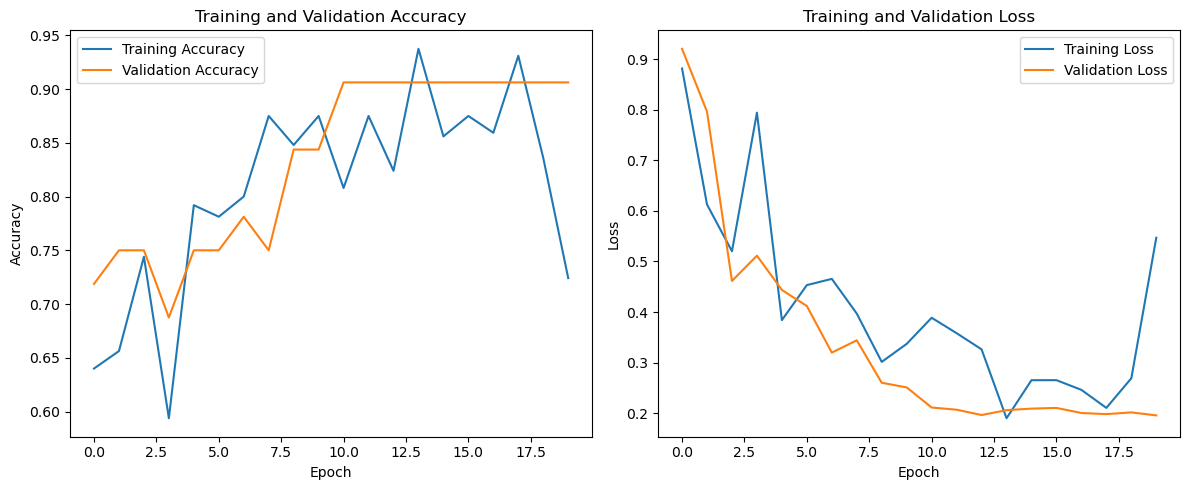

In [21]:
# 3. Training and Validation Loss and Accuracy (Combined Plot)
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


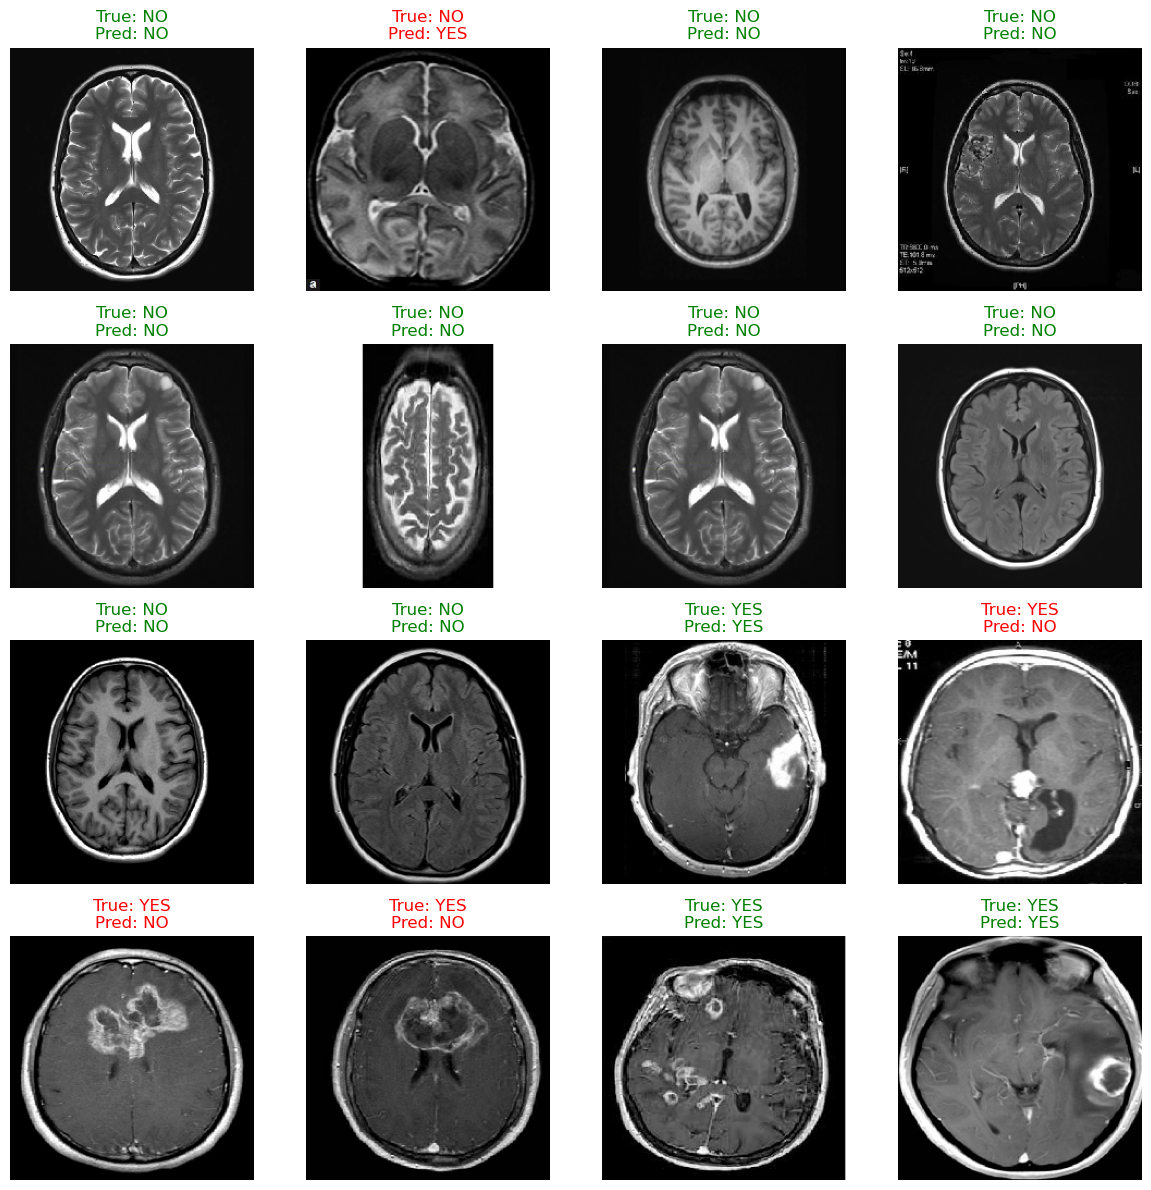

In [41]:
'''
A grid of 16 test images have been displayed with the corrected and predicted labels.
Provides a comparision with the actual and predicted result
Correct: green, wrong: red
'''


# Get batch of test images and labels
test_images, test_labels = next(test_generator)  # Fetch a batch of test images

# Get predictions
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

# Plot the results
fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # Adjust grid size as needed
axes = axes.flatten()

for i in range(16):  # Show first 16 images
    img = test_images[i]
    true_label = "YES" if test_labels[i] == 1 else "NO"
    pred_label = "YES" if predicted_labels[i] == 1 else "NO"

    color = "green" if test_labels[i] == predicted_labels[i] else "red"  # Green = Correct, Red = Incorrect

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()

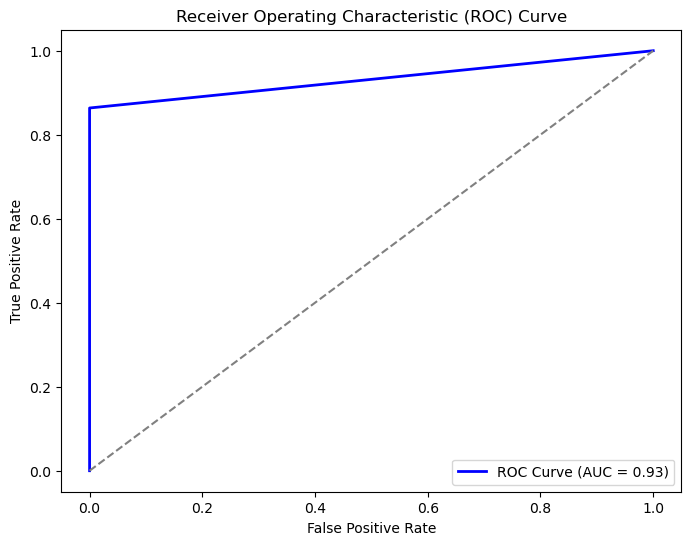

In [23]:
'''
ROC(Receiver Operating Characteristic Curve):
Graphical representation of a model's performance across all classification thresholds.
The ROC curve plots the sensitivity(true positive rate) aginst false positive rate.
AUC (Area Under the ROC Curve):
Provides a number(0-1) that summarizes the performance
Higher AUC score indicates that the model is good in distinguishing between two classes.
'''
#ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

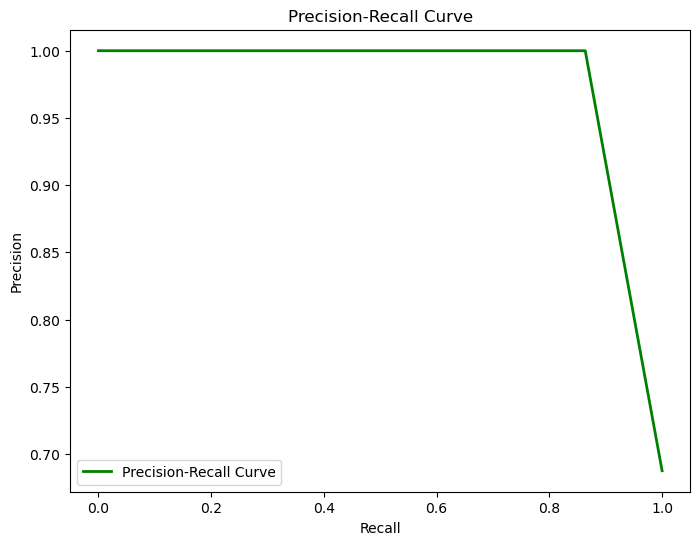

In [24]:
'''
Precision- recall curve is used because the provided dataset is imbalanced. 
Shows trade-off between precision and recall for different thresholds. 
Higher Area under the curve = good performance. 
'''
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

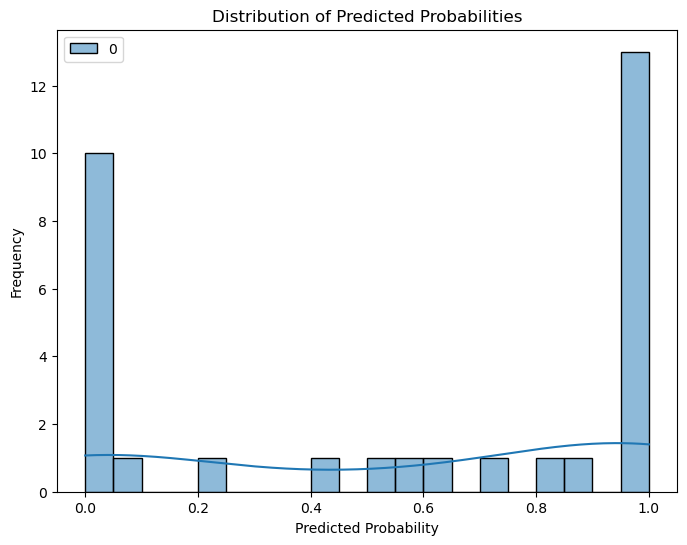

In [25]:
'''
Identify if the model is confident with the prdictions. 
'''

# Distribution of Predictions
plt.figure(figsize=(8, 6))
sns.histplot(predictions, bins=20, kde=True, color='purple')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,286,913 (39.24 MB)

 Trainable params: 8,028,673 (30.63 MB)

 Non-trainable params: 2,258,240 (8.61 MB)